In [103]:
#s3_data ="s3://aegovan-data/test_unique_pub_v3_lessnegatve_predicted_linear.json"
data_dir = "temp"

In [104]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008 $data_dir --recursive --exclude "*"  --include "*.json" --exclude "*vocab.json" --include "*.log"

download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/training_scores_epoch_Objectdump_20190909_131343_445f2544-789e-4c08-9f72-5a85c53d4f1b.json to temp/training_scores_epoch_Objectdump_20190909_131343_445f2544-789e-4c08-9f72-5a85c53d4f1b.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/validation_scores_epoch_Objectdump_20190909_131343_5980a68d-3c92-48cb-af94-7cd2c807f9ae.json to temp/validation_scores_epoch_Objectdump_20190909_131343_5980a68d-3c92-48cb-af94-7cd2c807f9ae.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/run.log to temp/run.log
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/predicted_AIMedval.json to temp/predicted_AIMedval.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/predicted_AIMedtest.json to temp/predicted_AIMedtest.json


In [105]:
import pandas
import matplotlib.pyplot as plt

In [106]:
!ls  $data_dir

predicted_AIMedtest.json
predicted_AIMedval.json
run.log
training_scores_epoch_Objectdump_20190909_131343_445f2544-789e-4c08-9f72-5a85c53d4f1b.json
validation_scores_epoch_Objectdump_20190909_131343_5980a68d-3c92-48cb-af94-7cd2c807f9ae.json


In [107]:
!head -1 $data_dir/run.log 

commit 075193db228696f558bbbcf127413bb27467a342


In [108]:
!head -10 $data_dir/run.log | tail -8

Date:   Mon Sep 9 19:55:47 2019 +1000

    Use pad zero tokens
{'dataset': 'PpiAimedDataset', 'trainjson': '/data/AIMedtrain.json', 'valjson': '/data/AIMedval.json', 'embedding': '/data/wikipedia-pubmed-and-PMC-w2v.bin.txt', 'embeddim': 200, 'outdir': '/data/model_PpiAimedDataset_CnnPos_190909_1008', 'epochs': 200, 'interaction_type': None, 'log_level': 'INFO'}
2019-09-09 10:08:03,570 - __main__ - INFO - The embedding header is 5443656 200

2019-09-09 10:08:03,571 - algorithms.RelationExtractorBiLstmNetwork - INFO - The text feature is index 0, the feature lengths are [150   1   1]
2019-09-09 10:08:03,572 - algorithms.RelationExtractorBiLstmNetwork - INFO - Word embedding size is 200, pos embedding size is 6, totaldim is 206, hidden_size  150


In [109]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [110]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [124]:
import glob

results_file = "./{}/predicted_AIMedtest.json".format(data_dir)
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [112]:
#download_single_file(s3_data, results_file)

In [125]:
import pandas as pd

In [126]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["isValid"]

In [127]:
df_results.head(n=3)

,docid,isValid,line_no,participant1,participant2,passage,predicted,confidence_scores,confidence_true,confidence_false,actual
0,abstract_11780382,False,6,IFN - alpha,IL - 4,"Cytokines measurements during IFN - alpha treatment showed a trend to decreasing levels of IL - 4 at 4 , 12 , and 24 weeks .",False,"{'False': 13.0466365814, 'True': -5.5720143318}",0.003803,463534.725531,False
1,abstract_11780382,False,7,IFN - alpha,IFN - gamma,Levels of IFN - gamma were slightly increased following IFN - alpha treatment ( P = 0.09 ) .,False,"{'False': 11.8266267776, 'True': -5.3124694824}",0.004930,136848.092759,False
1020,abstract_for_1833068,False,1,CDC2,cyclin E,"TI - Human cyclin E , a new cyclin that interacts with two members of the CDC2 gene family .",False,"{'False': 7.8738045692, 'True': -4.1671004295}",0.015497,2627.543266,False


In [128]:
df_results.columns


Index(['docid', 'isValid', 'line_no', 'participant1', 'participant2',
       'passage', 'predicted', 'confidence_scores', 'confidence_true',
       'confidence_false', 'actual'],
      dtype='object')

In [129]:
df_results.shape

(590, 11)

## Analyse Results

In [35]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [36]:
df = df_results

In [37]:
df_results.shape

(590, 11)

In [38]:
import math

# This is log softmax, convert to softmax prob
df["true"]  =df["confidence_scores"].apply(lambda x: math.exp(x["True"]))
df["false"]  =df["confidence_scores"].apply(lambda x: math.exp(x["False"]))

df[ ["true", "false", "actual", "predicted", "confidence_scores"]].sort_values(["true"], ascending=False).head(n=3)

,true,false,actual,predicted,confidence_scores
1665,73.278145,0.117768,True,True,"{'False': -2.1390388012, 'True': 4.2942624092}"
1881,54.141435,0.067151,True,True,"{'False': -2.7008144855, 'True': 3.9915997982}"
2924,22.998443,0.209310,True,True,"{'False': -1.5639388561, 'True': 3.1354265213}"


In [39]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df["actual"], df["predicted"], sample_weight=None)  
accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))



The F1 score is 0.41237113402061853 and the accuracy is 0.8067796610169492


In [40]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.18.4 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


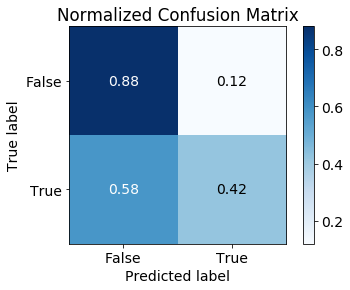

In [41]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True )
plt.show()

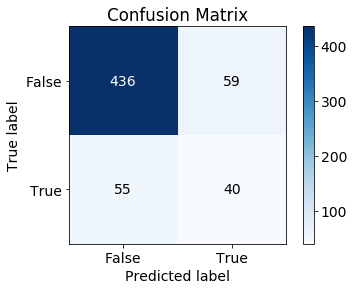

In [42]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False )
plt.show()

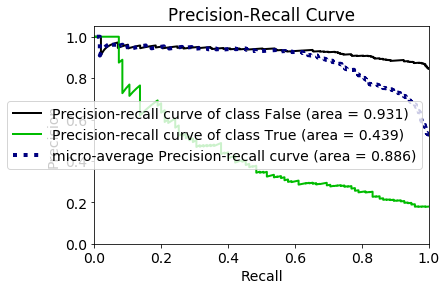

In [43]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[["false", "true"]])

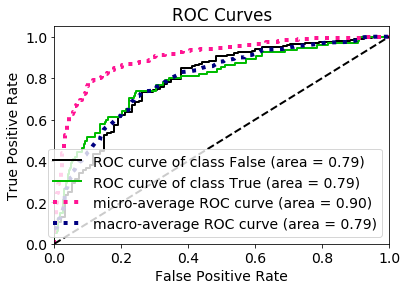

In [61]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_roc(df["actual"], df[["false", "true"]])

## Training / Validation epoch fit

In [44]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [45]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] = df_train_fit["score"] * 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)


,epoch,loss,score
39,39,1.238613,98.166432
42,42,2.225085,97.602257
38,38,2.165141,97.464789
40,40,1.653239,97.297297
37,37,1.858943,96.737589
34,34,2.861336,96.348315
35,35,3.234205,95.590327
32,32,3.138373,95.319149
41,41,2.734490,94.452347
31,31,3.808084,93.714286


In [46]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] = df_val_fit["score"] * 100
df_val_fit.sort_values(["loss"], ascending=True).head(n=10)

,epoch,loss,score
10,10,3.212561,42.424242
7,7,3.261491,31.578947
8,8,3.274903,43.076923
11,11,3.474388,52.380952
5,5,3.638801,9.302326
4,4,3.674910,0.000000
2,2,3.771210,0.000000
6,6,3.773231,36.065574
12,12,3.845643,54.347826
3,3,4.008905,33.333333


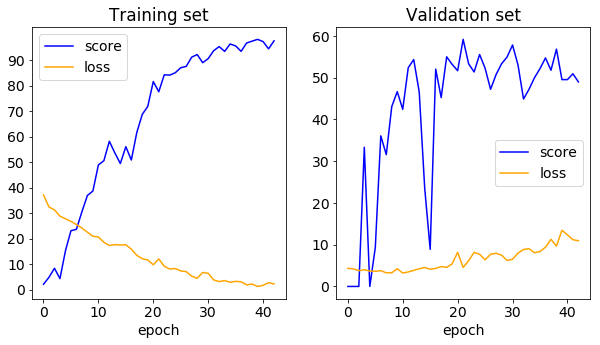

In [47]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color="orange")
ax[0].set_title("Training set")
ax[0].yaxis.set_major_locator(plt.FixedLocator( range(0, 100, 10)))

df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color ="orange")

ax[1].set_title("Validation set")
ax[1].yaxis.set_major_locator(plt.FixedLocator(range(0, 100,10)))



plt.show()

### Threshold 

In [48]:
threshold = .95
df_trues = df.query("true > {}".format(threshold))
df_trues.shape

(141, 13)

In [49]:
from sklearn.metrics import f1_score, accuracy_score, precision_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"])  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
precision = precision_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)


print("The F1 score is {} and the accuracy is {}, precision {}".format(f1, accuracy, precision))

The F1 score is 0.5405405405405406 and the accuracy is 0.5177304964539007, precision 0.40404040404040403


### BERT Variance

In [193]:
import boto3
import re

def search_log(stream_names, filter_pattern, regex_pattern):
    client = boto3.client('logs')

    log_group_name= "/aws/sagemaker/TrainingJobs"

    response = client.filter_log_events(
        logGroupName=log_group_name,
        logStreamNames=stream_names,
        filterPattern= filter_pattern,
        limit=10,
        interleaved=False
    )

    assert len(response["events"]) == 1
    log_message = response["events"][0]["message"]
    
    # extract the cm from string
    prog = re.compile(regex_pattern)
    result = prog.match(log_message)
    
    return result
    
def get_confusion_matrix(stream_names, filter_pattern=None):

    
    filterPattern = filter_pattern or '"algorithms.TrainWorkflow - INFO - Confusion matrix: "'
    regex_pattern = ".*tn, fp, fn, tp  is \[(\d+\s+\d+\s+\d+\s+\d+\s*)\]"
    
    result = search_log(stream_names, filterPattern, regex_pattern).group(1)


    # normalise string to remove extra space
    result = re.sub("\s+", " ", result) 
    
    # split the string, sep by space..514 62 41 75
    tn, fp, fn, tp = result.split(" ")
    return {"tn":int(tn), "fp":int(fp), "fn":int(fn), "tp":int(tp)}


def get_prf_bert(stream_names):
    filterPattern =  '"__main__ - INFO - binary average scores"'
    regex_pattern = ".*precision, recall, fscore, support\s+\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    result = search_log(stream_names, filterPattern, regex_pattern).group(1)

    # normalise string to remove extra space
    result = re.sub("\s+", "", result) 
    
    # split the string, sep by comma..514 62 41 75
    precision, recall, fscore = result.split(",")
    
    return float(precision), float(recall), float(fscore)



def get_confusion_matrix_bert(stream_names):
    filter_pattern = '"__main__ - INFO - Confusion matrix:"'
    return get_confusion_matrix(stream_names,filter_pattern)


def get_log_name(sagemaker_job_name):
    client = boto3.client('logs')
    log_group_name= "/aws/sagemaker/TrainingJobs"
    
    response = client.describe_log_streams(
    logGroupName=log_group_name,
    logStreamNamePrefix=sagemaker_job_name,
    orderBy='LogStreamName',
    descending=False,
    limit=5
)
    assert len(response["logStreams"]) == 1
    
    return  response["logStreams"][0]["logStreamName"]

In [35]:
#precision, recall, fscore
val_scores_bert = {
"aimed-bert-plain-split-2019-11-26-17-06-43-047/algo-1-1574788218" : [0.6612903225806451, 0.6721311475409836, 0.6666666666666666],
"aimed-bert-plain-split-2019-11-26-17-05-51-125/algo-1-1574788124":   [0.6617647058823529, 0.7377049180327869, 0.6976744186046512],
"aimed-bert-plain-split-2019-11-26-17-05-15-304/algo-1-1574788082": [0.8333333333333334, 0.7377049180327869, 0.782608695652174],
"aimed-bert-plain-split-2019-11-26-17-04-37-299/algo-1-1574788037":   [0.6268656716417911, 0.6885245901639344, 0.6562500000000001],
"aimed-bert-plain-split-2019-11-26-17-04-01-076/algo-1-1574788008":  [0.6557377049180327, 0.6557377049180327, 0.6557377049180327],
"aimed-bert-plain-split-2019-11-26-09-34-15-420/algo-1-1574761423":[0.8301886792452831, 0.7213114754098361, 0.7719298245614035] ,
"aimed-bert-plain-split-2019-11-26-08-50-05-531/algo-1-1574758989":   [0.6133333333333333, 0.7540983606557377, 0.676470588235294],
"aimed-bert-plain-split-2019-11-26-08-30-38-244/algo-1-1574757524"  : [0.7727272727272727, 0.8360655737704918, 0.8031496062992125],
"aimed-bert-plain-split-2019-11-26-08-20-05-323/algo-1-1574757170"  :  [0.7068965517241379, 0.6721311475409836, 0.6890756302521007],
"aimed-bert-plain-split-2019-11-26-08-02-54-028/algo-1-1574756055":[0.6964285714285714, 0.639344262295082, 0.6666666666666667]
    
}

In [155]:
bert_jobs = ["aimed-bert-plain-split-2019-12-27-02-26-02-690",
"aimed-bert-plain-split-2019-12-27-02-25-43-027",
"aimed-bert-plain-split-2019-12-27-02-25-28-691",
"aimed-bert-plain-split-2019-12-27-02-25-09-463",
"aimed-bert-plain-split-2019-12-27-02-24-48-346",
"aimed-bert-plain-split-2019-12-27-02-24-16-129",
"aimed-bert-plain-split-2019-12-27-02-23-47-725",
"aimed-bert-plain-split-2019-12-27-02-23-27-656",
"aimed-bert-plain-split-2019-12-27-02-23-02-670",
"aimed-bert-plain-split-2019-12-27-02-22-35-468",]

In [194]:
scores_bert = {}
for k in bert_jobs:
    l = get_log_name(k)
    (p,r,f) = get_prf_bert([l])
    cm  = get_confusion_matrix_bert([l]) 
    scores_bert[k] = {"fpr":(p,r,f) , "cm" : cm }




In [196]:
import pandas as pd 

def create_variation_df(scores_map):
    result = []
    for k in scores_map:
        p,r,f=scores_map[k]["fpr"]
        cm = scores_map[k]["cm"]
       
        accuracy = float(cm["tp"] + cm["tn"])/float(cm["tp"] + cm["tn"] + cm["fp"] + cm["fn"])
        b= float( cm["tn"] +  cm["fp"]  )/float(cm["tp"] + cm["tn"] + cm["fp"] + cm["fn"])
        result.append({"Precision": p *100, "Recall": r*100, "F1-score": f * 100, "Accuracy": accuracy*100, "BaselineAcc":b*100})

    df =  pd.DataFrame(result)
    return df

In [197]:
df_val_scores_bert = create_variation_df(scores_bert)
df_val_scores_bert.describe()

,Accuracy,BaselineAcc,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,89.034335,81.974249,68.407107,71.444574,66.071429
std,1.249026,0.000000,3.668703,5.028211,6.204959
min,87.339056,81.974249,64.242424,64.835165,58.333333
25%,88.251073,81.974249,66.021505,68.187831,61.309524
50%,88.733906,81.974249,67.275930,71.130952,64.285714
75%,89.699571,81.974249,69.910911,74.207746,69.940476
max,91.416309,81.974249,76.744186,79.104478,78.571429


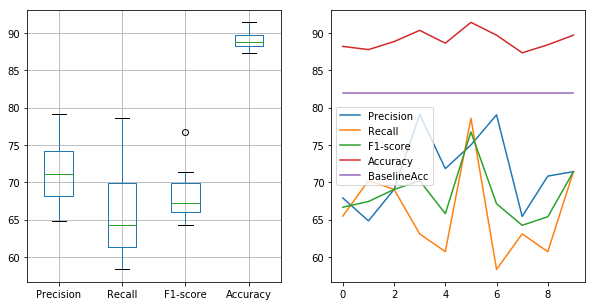

In [198]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5))

df_val_scores_bert[["Precision", "Recall", "F1-score", "Accuracy"]].boxplot(ax=ax[0])
df_val_scores_bert[["Precision", "Recall", "F1-score","Accuracy", "BaselineAcc"]].plot(ax = ax[1])

plt.savefig("score_variation_aimed_bert.png", bbox_inches='tight')




In [44]:
df_val_scores_bert.describe()

,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000
mean,70.662298,70.585661,71.147541
std,5.673831,7.993936,5.844696
min,65.573770,61.333333,63.934426
25%,66.666667,65.712586,67.213115
50%,68.277311,67.909664,70.491803
75%,75.336597,75.626959,73.770492
max,80.314961,83.333333,83.606557


### LSTM Variance no overlap

In [70]:
#cm format Confusion matrix: tn, fp, fn, tp

val_scores_bilstm = {"aimed-bilstm-split-2019-11-27-06-39-08-788/algo-1-1574836892":  [0.5474452554744526, 0.646551724137931, 0.5928853754940712] 
             ,"aimed-bilstm-split-2019-11-27-06-38-40-798/algo-1-1574836867":[0.5483870967741935, 0.5862068965517241, 0.5666666666666665]
            ,"aimed-bilstm-split-2019-11-27-06-38-11-353/algo-1-1574836842":[0.6018518518518519, 0.5603448275862069, 0.5803571428571428]
             ,"aimed-bilstm-split-2019-11-27-06-37-44-821/algo-1-1574836805":[0.6017699115044248, 0.5862068965517241, 0.593886462882096]
              ,"aimed-bilstm-split-2019-11-27-06-37-15-734/algo-1-1574836784":[0.63, 0.5431034482758621, 0.5833333333333334]
              ,"aimed-bilstm-split-2019-11-27-06-36-08-149/algo-1-1574836753":[0.5433070866141733, 0.5948275862068966, 0.567901234567901]
              ,"aimed-bilstm-split-2019-11-27-06-35-12-977/algo-1-1574836710":[0.6057692307692307, 0.5431034482758621, 0.5727272727272726]
              ,"aimed-bilstm-split-2019-11-27-06-34-33-811/algo-1-1574836631":[0.5887850467289719, 0.5431034482758621, 0.5650224215246636]
              ,"aimed-bilstm-split-2019-11-27-06-33-56-153/algo-1-1574836619":[0.5692307692307692, 0.6379310344827587, 0.6016260162601627]
              ,"aimed-bilstm-split-2019-11-27-06-33-07-585/algo-1-1574836554":[0.5588235294117647, 0.6551724137931034, 0.6031746031746031]
             }



In [85]:
scores_bilstm = {}
for k in val_scores_bilstm:
    cm  = get_confusion_matrix([k]) 
    scores_bilstm[k] = {"fpr":val_scores_bilstm[k] , "cm" : cm }



In [100]:
sum(list(scores_bilstm["aimed-bilstm-split-2019-11-27-06-36-08-149/algo-1-1574836753"]["cm"].values()))

692

In [88]:
df_val_scores_bilstm = create_variation_df(scores_bilstm)

df_val_scores_bilstm.describe()

,Accuracy,BaselineAcc,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,85.867052,83.236994,58.275805,57.953698,58.965517
std,0.739367,0.000000,1.453028,3.011182,4.380653
min,84.826590,83.236994,56.502242,54.330709,54.310345
25%,85.223988,83.236994,56.910774,55.099620,54.741379
50%,85.910405,83.236994,58.184524,57.900791,58.620690
75%,86.416185,83.236994,59.363619,60.183137,62.715517
max,86.994220,83.236994,60.317460,63.000000,65.517241


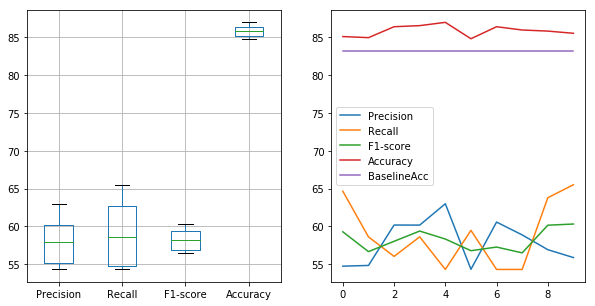

In [87]:

fig, ax = plt.subplots(1,2, figsize=(10, 5))
df_val_scores_bilstm[["Precision", "Recall", "F1-score", "Accuracy"]].boxplot(ax=ax[0])
df_val_scores_bilstm[["Precision", "Recall", "F1-score", "Accuracy", "BaselineAcc"]].plot(ax = ax[1])

plt.savefig("score_variation_aimed_bilstm.png", bbox_inches='tight')





In [32]:
df_val_scores_bilstm.describe()

,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000
mean,58.275805,57.953698,58.965517
std,1.453028,3.011182,4.380653
min,56.502242,54.330709,54.310345
25%,56.910774,55.099620,54.741379
50%,58.184524,57.900791,58.620690
75%,59.363619,60.183137,62.715517
max,60.317460,63.000000,65.517241


In [42]:


def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm


def standardize( df):

    avg = df.mean()
    stdv = df.std()
    series_standardized = (df - avg)/ stdv
    return series_standardized


In [43]:


df_val_scores_bilstm_norm =standardize(df_val_scores_bilstm)

df_val_scores_bilstm_norm.describe()

,F1-score,Precision,Recall
count,1.000000e+01,1.000000e+01,1.000000e+01
mean,1.976197e-15,-1.187939e-15,-1.620926e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.220598e+00,-1.203178e+00,-1.062666e+00
25%,-9.394386e-01,-9.478262e-01,-9.642714e-01
50%,-6.282155e-02,-1.757017e-02,-7.871603e-02
75%,7.486529e-01,7.403866e-01,8.560368e-01
max,1.405103e+00,1.675854e+00,1.495605e+00


In [135]:
sum([441   , 59 ,   39,    69])

608

In [137]:
#bert
sum([471 ,   39  ,  41  ,  66])
#sum([473, 22, 22, 67])

617